<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

import collections

In [2]:
# замените на свой путь
PATH_TO_DATA = r'C:\Users\nspap\_jupiter_work'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def glob(path):
    """Возвращает названия всех .csv файлов в папке"""
    return [name for name in os.listdir(path) if name.endswith(".csv")]


def convert_to_csr(X):
    """Преобразует данные в разреженную матрицу"""
    row_ind = X.flatten()
    data = [1] * X.shape[0] * X.shape[1]
    col_ind = [X.shape[1] * x for x in range(X.shape[0] + 1)]
    X_csr = csr_matrix((data, row_ind, col_ind), dtype=int)[:,1:]
    return X_csr

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    # считаем словарь для частот посещений сайтов из файла, сохраненного в первом задании
    with open(site_freq_path, "rb") as f_in:
        site_freq = pickle.load(f_in) 
    # получим имена файлов в папке
    files = glob(path_to_csv_files)
    train_data = []  # основной датафрейм для обучающих данных
  
    # пройдем в цикле по всем файлам и заполним ДФ для обучения
    for file_name in files:
        users_data = pd.read_csv(os.path.join(path_to_csv_files, file_name))
        user_id = int(file_name[4:-4]) # id пользователя из имени файла        
        # преобразуем столбец времени в pd.datetime
        users_data.timestamp = users_data.timestamp.apply(pd.to_datetime)  
        # sc == id сессии пользователя
        for sc in range((users_data.shape[0]-1) // window_size + 1):
            user_d = [] # массив для собирания данных о пользователе
            # i-й сайт в сессии
            session_start_time = users_data.timestamp[sc * window_size] # время начала сессии
            session_end_time = 0 # переменная для хранения времени посещения последнего сайта в сессии            
            for i in range(session_length):
                curr_site_id = sc * window_size + i
                if curr_site_id < users_data.shape[0]:
                    user_d.append(site_freq[users_data.site[curr_site_id]][0])
                    session_end_time = users_data.timestamp[curr_site_id]
                else:
                    user_d.append(0)
            # посчитаем количество уникальных элементов 
            uniq = collections.Counter(user_d)
            if 0 in uniq:
                del uniq[0]
            
            user_d.append((session_end_time - session_start_time).seconds)
            user_d.append(len(uniq))
            user_d.append(session_start_time.hour)
            user_d.append(session_start_time.dayofweek)
            user_d.append(user_id)
            train_data.append(user_d)    
    train_data = pd.DataFrame(train_data, columns=feature_names)
    return train_data

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [6]:
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,9,2,1,7,6,8,10,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,6,11,3,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 11.1 s


In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,577,134,3,134,134,3,134,203,134,33,5,8,4,31
1,425,193,687,254,134,31,394,3841,218,55,284,10,8,4,31
2,55,3,55,55,5,293,425,340,908,55,258,7,8,4,31
3,473,4015,473,55,55,55,55,980,201,123,30,6,8,4,31
4,348,55,5,3837,258,212,3937,2157,676,2157,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1min 48s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [11]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [40]:
id_name_dict = {
    128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
    33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [41]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

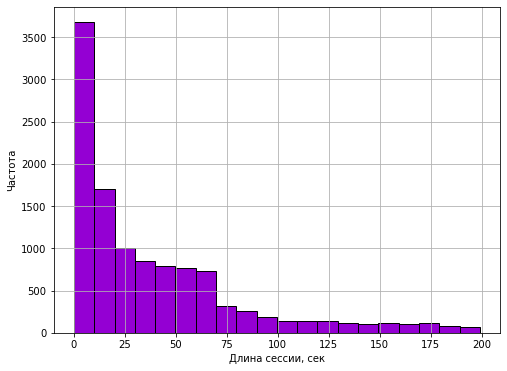

In [15]:
session_timespan_200 = train_data_10users['session_timespan'][train_data_10users['session_timespan'] < 200]
session_timespan_200.hist(color='darkviolet', edgecolor='k', figsize=(8, 6), bins=20) \
            .set(xlabel='Длина сессии, сек', ylabel='Частота')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

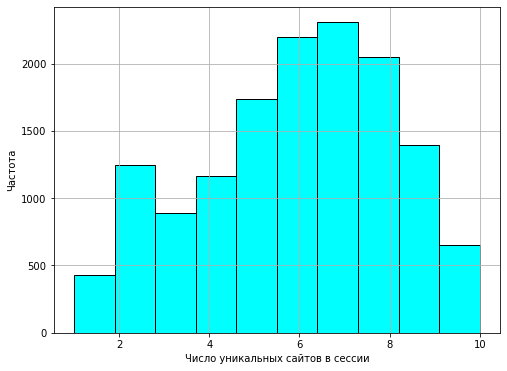

In [16]:
train_data_10users['#unique_sites'].hist(color='aqua', edgecolor='k', figsize=(8, 6)) \
            .set(xlabel='Число уникальных сайтов в сессии', ylabel='Частота')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

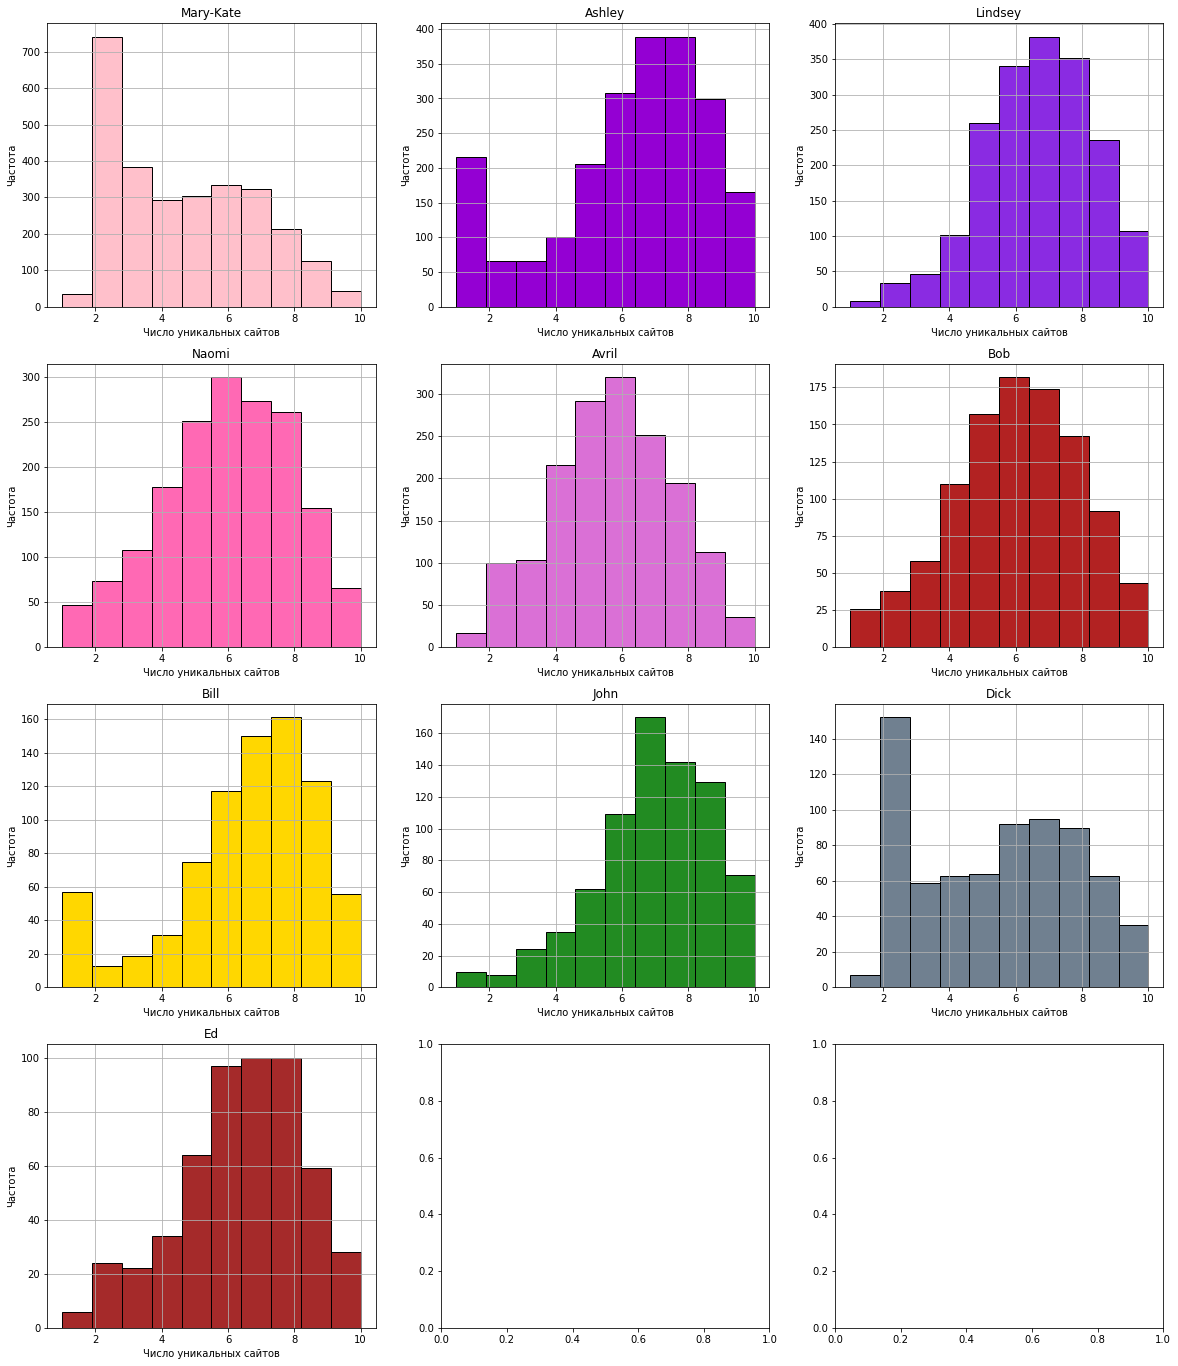

In [17]:
fig, axes = plt.subplots(4, 3, figsize = (20, 24))
pos = 0
for name in id_name_dict.values():
    train_data_10users['#unique_sites'][train_data_10users.target==name].plot(
        kind='hist', ax=axes[pos // 3, pos % 3], color=color_dic[name], edgecolor='k', title=name, grid=True, bins=10).set(
        xlabel='Число уникальных сайтов', ylabel='Частота', label=name)
    pos += 1

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

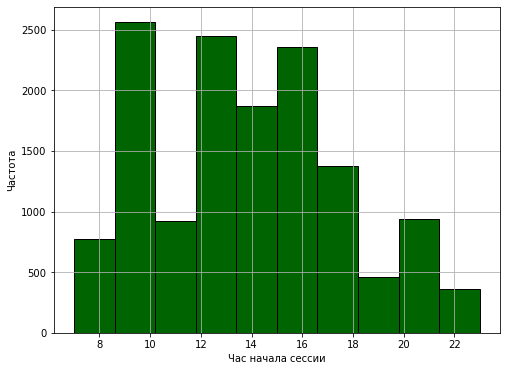

In [18]:
train_data_10users['start_hour'].hist(color='darkgreen', edgecolor='k', figsize=(8, 6)).set(
    xlabel='Час начала сессии', ylabel='Частота')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

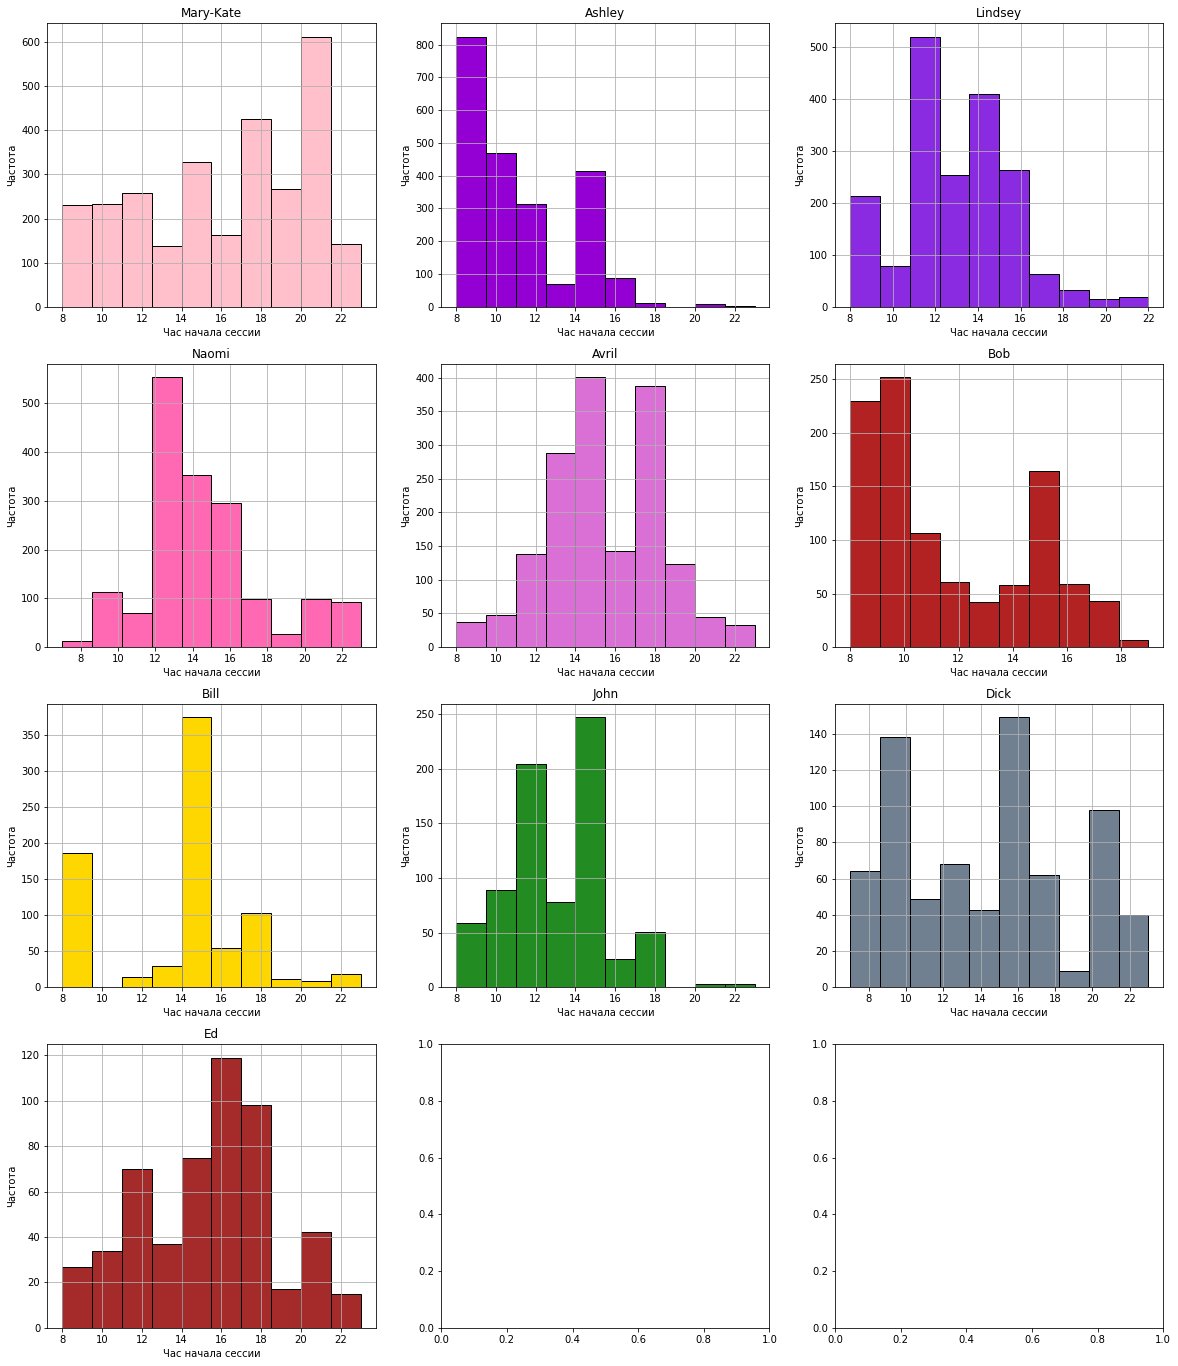

In [19]:
fig, axes = plt.subplots(4, 3, figsize = (20, 24))
pos = 0
for name in id_name_dict.values():
    train_data_10users['start_hour'][train_data_10users.target==name].plot(
        kind='hist', ax=axes[pos // 3, pos % 3], color=color_dic[name], edgecolor='k', title=name, grid=True).set(
        xlabel='Час начала сессии', ylabel='Частота', label=name)
    pos += 1

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

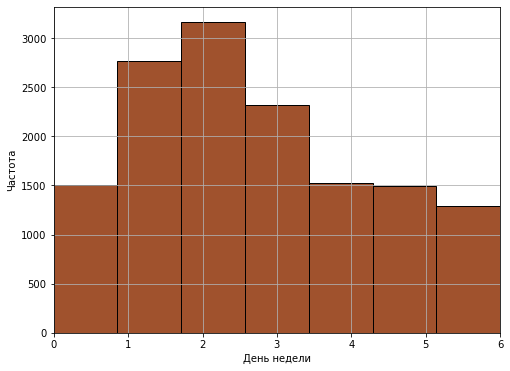

In [20]:
train_data_10users['day_of_week'].hist(color='sienna', edgecolor='k', figsize=(8, 6), bins=7).set(
    xlabel='День недели', ylabel='Частота', xlim=[0, 6])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

In [21]:
train_data_10users['day_of_week'].value_counts()

2    3163
1    2772
3    2316
4    1520
0    1505
5    1494
6    1291
Name: day_of_week, dtype: int64

In [22]:
days_of_week = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

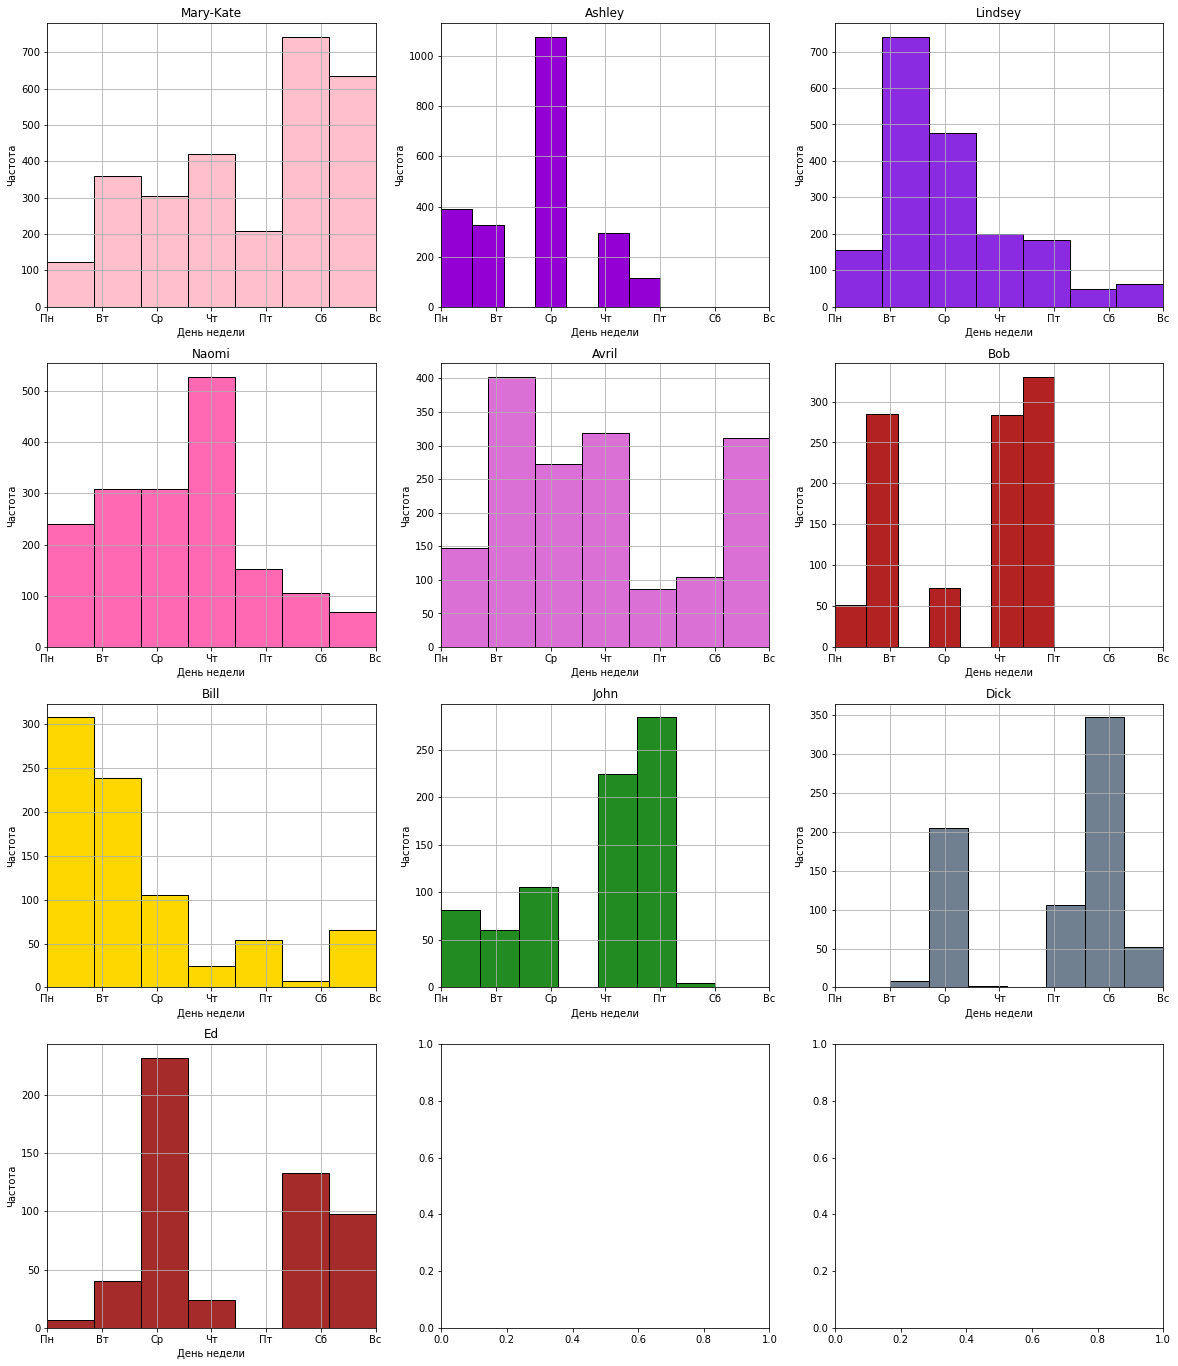

In [23]:
fig, axes = plt.subplots(4, 3, figsize = (20, 24))
pos = 0
for name in id_name_dict.values():
    train_data_10users['day_of_week'][train_data_10users.target==name].plot(
        kind='hist', ax=axes[pos // 3, pos % 3], color=color_dic[name], edgecolor='k', title=name, grid=True, bins=7).set(
        xlabel='День недели', xticklabels=days_of_week, ylabel='Частота', label=name, xlim=[0, 6])
    pos += 1

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

In [24]:
# количество сессий у разных пользователей
train_data_10users['target'].value_counts()

Mary-Kate    2796
Ashley       2204
Lindsey      1868
Naomi        1712
Avril        1643
Bob          1022
Bill          802
John          760
Dick          720
Ed            534
Name: target, dtype: int64

Хоть и есть схожие паттерны поведения (особенно в количестве уникальных сайтов), но в целом пользователи довольно сильно отличаются.
* Mary-Kate - она в принципе гораздо чаще остальных заходит на сайты. При этом большинство сессий имеет 2 уникальных сайта. В этом её поведение схоже с Dick'ом, правда тот гораздо реже заходит в интернет. Её активность более-менее равномерно распределена в течении дня и заметно увеличивается к вечеру. Похоже и с днями недели - маленькая активность в понедельние, средняя в течении недели и высокая на выходных.
* Ashley напротив, не заходит в сеть в выходные и по вечерам, основная активность приходится на утро и будние дни. В сессиях или один уникальный сайт, или довольно много разных сайтов.
* Lindsey - основная активность приходится на вторник с постепенным уменьшением к выходным. Чаще всего это середина дня, очень низкая активность вечером. В большинстве сессий много (6-8) уникальных сайтов.
* Naomi довольно сильно похожа на Линдси, главные отличия - гораздо ниже активность рано утром, и основной день не вторник, а четверг.
* Avril - количество уникальных сайтов имеет практически нормальное распределение со средним = 6. Основное время в сети - 15 и 18 часов со вторника по четверг + воскресение. 
* Bob - как и все последующие пользователи меньше , чем предыдущие пользователи сидит в интернете, но когда заходит, посещает сразу много разных сайтов. Пик активности - вт, чт, пц утро и 15 часов.
* Bill - так же, как и Боб, посещает много разных сайтов. Основная активность 9 утра и 15 часов дня в пн и вт. 
* John - основные дни чт и пт, 12 и 15 дня, в среднем 7 уник сайтов.
* Dick и Ed - имеют схожее поведение - пики активности на среду и выходные, 16 часов дня. А вот распределение уникальных сайтов отличается.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [25]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), "rb") as f_in:
    site_freq = pickle.load(f_in)

In [26]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), "rb") as f_in:
    site_freqs = pd.DataFrame(pickle.load(f_in), index=['id', 'freq'])

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
top10 = site_freqs.loc['freq', :].sort_values(ascending=False)[:10]
top10_freqs = top10.tolist()
top10_sites = top10.index.tolist()

In [28]:
top10

s.youtube.com                           8300
www.google.fr                           7813
www.google.com                          5441
mail.google.com                         4158
www.facebook.com                        4141
apis.google.com                         3758
r3---sn-gxo5uxg-jqbe.googlevideo.com    3244
r1---sn-gxo5uxg-jqbe.googlevideo.com    3094
plus.google.com                         2630
accounts.google.com                     2089
Name: freq, dtype: int64

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

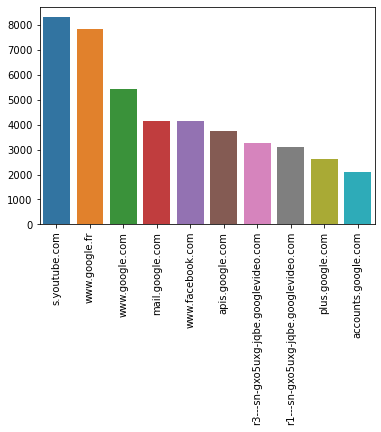

In [29]:
sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation=90)
plt.show()

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [30]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [31]:
train_data_10users.day_of_week.median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [43]:
train_data_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [44]:
train_data_150users['#unique_sites'].median() 

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Добавим один новый признак - посещение фейсбука в сессии. Мне кажется, что люди могу довольно сильно отличаться по частоте захода в соцсети, поэтому он может быть полезен. Отредактируем для этого функцию prepare_train_set_with_fe

In [34]:
def prepare_train_set_with_extra_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    # считаем словарь для частот посещений сайтов из файла, сохраненного в первом задании
    with open(site_freq_path, "rb") as f_in:
        site_freq = pickle.load(f_in) 
    # получим имена файлов в папке
    files = glob(path_to_csv_files)
    train_data = []  # основной датафрейм для обучающих данных
  
    # пройдем в цикле по всем файлам и заполним ДФ для обучения
    for file_name in files:
        users_data = pd.read_csv(os.path.join(path_to_csv_files, file_name))
        user_id = int(file_name[4:-4]) # id пользователя из имени файла        
        # преобразуем столбец времени в pd.datetime
        users_data.timestamp = users_data.timestamp.apply(pd.to_datetime)  
        # sc == id сессии пользователя
        for sc in range((users_data.shape[0]-1) // window_size + 1):
            user_d = [] # массив для собирания данных о пользователе
            facebook_count = 0 # счетчик посещения фейсбука
            # i-й сайт в сессии
            session_start_time = users_data.timestamp[sc * window_size] # время начала сессии
            session_end_time = 0 # переменная для хранения времени посещения последнего сайта в сессии            
            for i in range(session_length):
                curr_site_id = sc * window_size + i
                if curr_site_id < users_data.shape[0]:
                    user_d.append(site_freq[users_data.site[curr_site_id]][0])
                    session_end_time = users_data.timestamp[curr_site_id]
                    if users_data.site[curr_site_id] == 'www.facebook.com':
                        facebook_count += 1
                else:
                    user_d.append(0)
            # посчитаем количество уникальных элементов 
            uniq = collections.Counter(user_d)
            if 0 in uniq:
                del uniq[0]
            
            user_d.append((session_end_time - session_start_time).seconds)
            user_d.append(len(uniq))
            user_d.append(session_start_time.hour)
            user_d.append(session_start_time.dayofweek)
            user_d.append(facebook_count)
            user_d.append(user_id)
            train_data.append(user_d)    
    train_data = pd.DataFrame(train_data, columns=feature_names)
    return train_data

In [35]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'facebook_count', 'target']

In [36]:
%%time
train_data_10users = prepare_train_set_with_extra_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 12 s


In [37]:
%%time
train_data_150users = prepare_train_set_with_extra_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1min 56s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

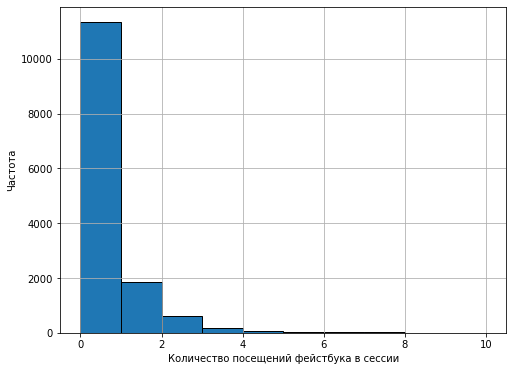

In [38]:
train_data_10users.facebook_count.hist(edgecolor='k', figsize=(8, 6)).set(
    xlabel='Количество посещений фейстбука в сессии', ylabel='Частота')
plt.show()

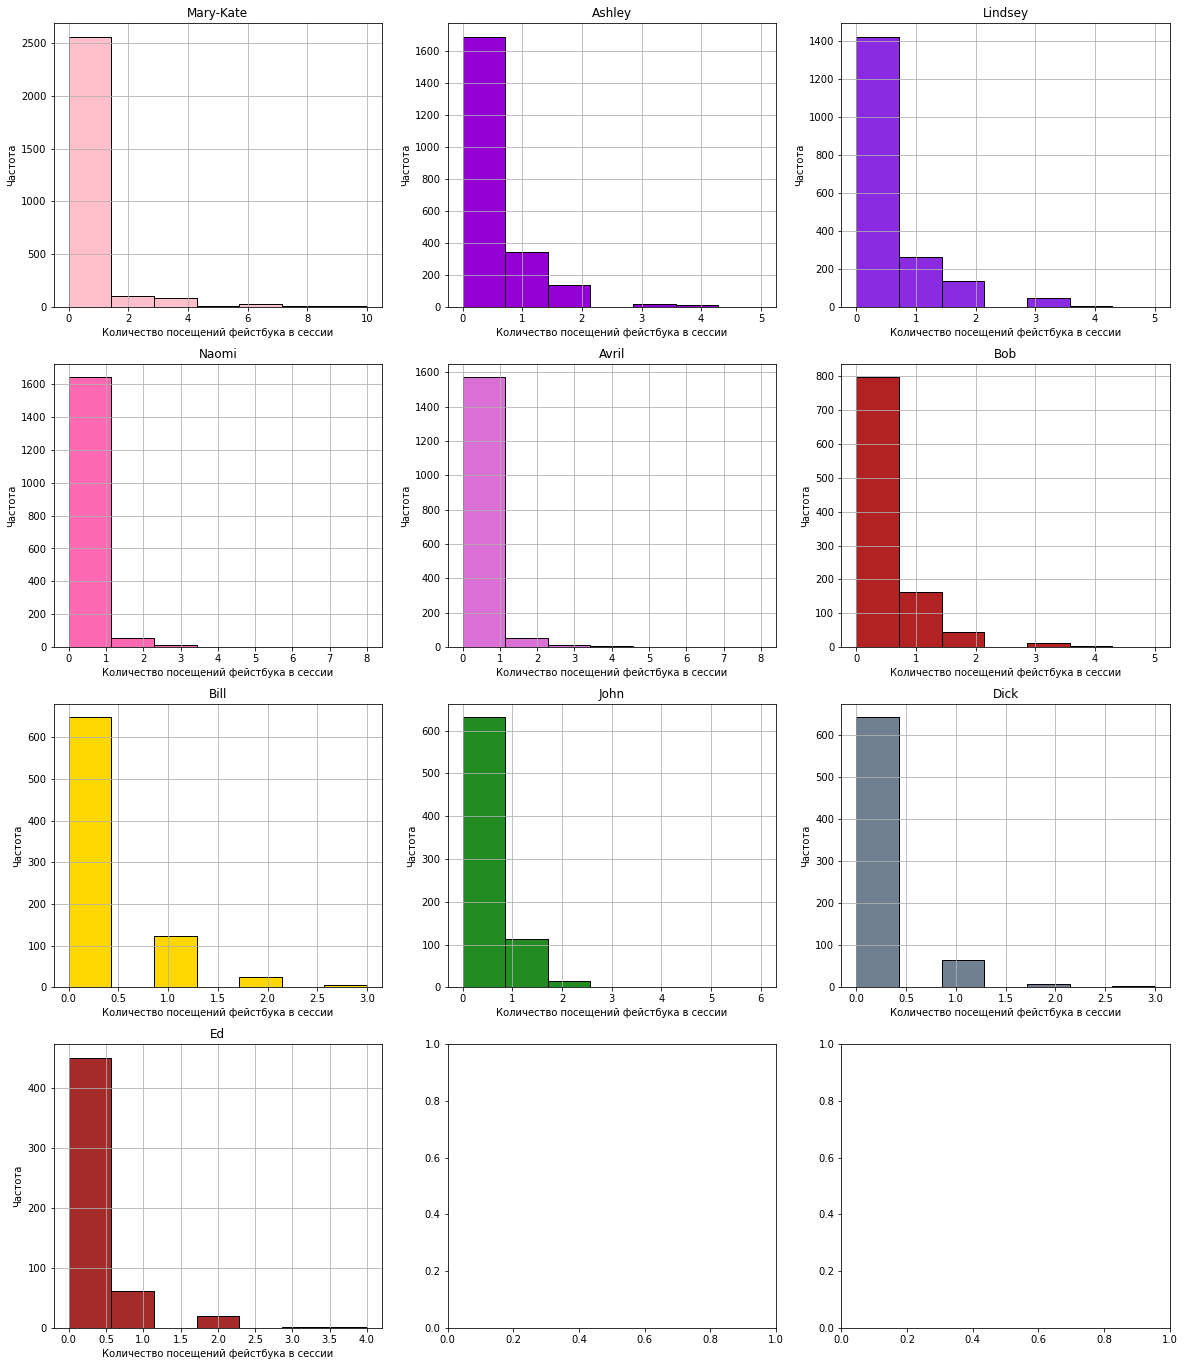

In [42]:
fig, axes = plt.subplots(4, 3, figsize = (20, 24))
pos = 0
for name in id_name_dict.values():
    train_data_10users['facebook_count'][train_data_10users.target==name].plot(
        kind='hist', ax=axes[pos // 3, pos % 3], color=color_dic[name], edgecolor='k', title=name, grid=True, bins=7).set(
        xlabel='Количество посещений фейстбука в сессии', ylabel='Частота', label=name)
    pos += 1

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

Признак получился не таким информативным, как хотелось, поэтому не будем его сохранять. Из ранее построенных признаков оставим все.

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 